# Compare similar flights to each other

In [1]:
## First import general packages for running python analysis:
import os, h5py, datetime,pytz, yaml
import numpy as np
from matplotlib.pyplot import *
from matplotlib import pyplot as plt
import pickle, glob

from scipy.interpolate import griddata
import scipy.optimize as opt
from scipy.optimize import curve_fit
from scipy.optimize import leastsq
from scipy.optimize import least_squares

from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm
from matplotlib.ticker import MultipleLocator

## Then import the beamcals module packages and initialize 'gbosite' class:
from beamcals import corr
from beamcals import concat
from beamcals import drone
from beamcals import bicolog
import beamcals.plotting_utils as pu
import beamcals.fitting_utils as fu
import beamcals.geometry_utils as gu
import beamcals.time_utils as tu
from beamcals.sites import site
gbosite=site.site('../beamcals/beamcals/sites/GBO_config.npz')

# various gridding attempts
import pykrige.kriging_tools as kt
from pykrige.ok import OrdinaryKriging

freqs = 800.0*np.ones(1024) + (-400/1024.)*np.arange(1024)

fitdir='/hirax/GBO_Analysis_Outputs/main_beam_fits/'
pckldir = '/hirax/GBO_Analysis_Outputs/flight_pickles/'

In [2]:
def get_newpointing(x,y,xc,yx,theta):
    xp = x - xc
    yp = y - yc
    xpp = np.cos(theta)*xp - np.sin(theta)*yp
    ypp = np.sin(theta)*xp + np.cos(theta)*yp
    return xpp, ypp

def get_slice(x,y,ty,val,tol):
    if ty=='x':
        ni = np.where(np.abs(x-val)<=tol)[0]
    if ty=='y':
        ni = np.where(np.abs(y-val)<=tol)[0]
    return ni

def Gauss_2d_cent(x,y,A,xsig,ysig,off):
    xx = ((x)**2)/(2*(xsig**2))
    yy = ((y)**2)/(2*(ysig**2))
    return A*np.exp(-1.0*(xx + yy))+off

def radial_profile(x,y,z,x0,y0):
    r = np.sqrt((x-x0)**2 + (y-y0)**2)
    r = r.astype(np.int)

    tbin = np.bincount(r.ravel(), z.ravel())
    nr = np.bincount(r.ravel())
    radialprofile = tbin / nr
    return radialprofile 

In [3]:
## Define anything I want to keep common
dotsize=1
freq_i = 900#10#350#900
ma = 50
mi = -50
res = 250#500

LX,LY = np.meshgrid(np.linspace(mi,ma,res), np.linspace(mi,ma,res))
X = np.arange(mi,ma,2.0,dtype='float64')
Y = np.arange(mi,ma,2.0,dtype='float64')
d=0

In [4]:
#flies = ['533','534','535','536','618','619','623','625','648','649','646','647','620','624']

fly = '648'

ffile = glob.glob(fitdir+'*'+fly+'*')[0]
pklfile = glob.glob(pckldir+'*'+fly+'*')[0]
print(ffile)
print(pklfile)

with open('/home/ln267/newburghlabdrone/analysis/GBO_flights_forscripts.yaml', 'r') as fff:
    documents = yaml.safe_load(fff)
flights = documents["flight_info"]["flights"]
N_pols = documents["flag_info"]["N_pols"]
E_pols = documents["flag_info"]["E_pols"]

for fi in range(0,len(documents["flight_info"]["flights"])):
    if fly == flights[fi]: f = fi
print(f, 'FLIGHT: ', documents["flight_info"]["flights"][f])

pol = documents["flight_info"]["pols"][f]

if pol=='N':
    pols = N_pols
    cpols = E_pols
else:
    pols = E_pols
    cpols = N_pols
    
print(fly,pol,pols,cpols)

/hirax/GBO_Analysis_Outputs/main_beam_fits/FLY648_20211022T191922Z_2dGauss_and_Airy_Params.npz
/hirax/GBO_Analysis_Outputs/flight_pickles/FLY648_20211022T191922Z_ver_20230413T002159_concat.pkl
11 FLIGHT:  648
648 E [0, 2, 8, 10, 14] [1, 3, 9, 11, 15]


# 1. Look at a single flight and examine fits

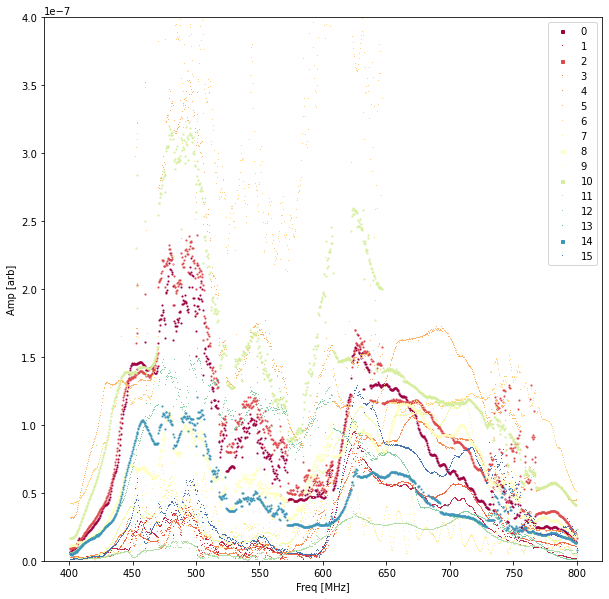

In [5]:
#######################
#### Gaussian fit #####
## check amplitudes ###
#######################


markers=['s',',']
msize=[1,3]

fits = np.load(ffile)

D = len(fits['G_popt'][:,0,0])
cm = plt.get_cmap('Spectral')
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.set_prop_cycle(color=[cm(1.*i/D) for i in range(D)])


for d in np.arange(0,D):
    if d in pols: 
        plt.plot(freqs,fits['G_popt'][d,:,0],marker=markers[0],ms=msize[0],linestyle='None',label=str(d))
    else: 
        plt.plot(freqs,fits['G_popt'][d,:,0],marker=markers[1],ms=msize[1],linestyle='None',label=str(d))
plt.ylim(0,4E-7)
plt.ylabel('Amp [arb]')
plt.xlabel('Freq [MHz]')
plt.legend(markerscale=3)
plt.show()



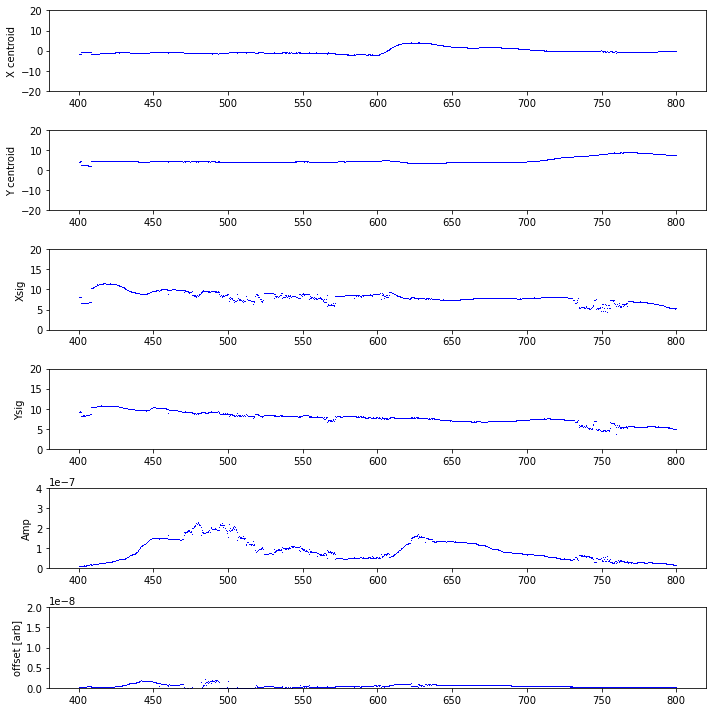

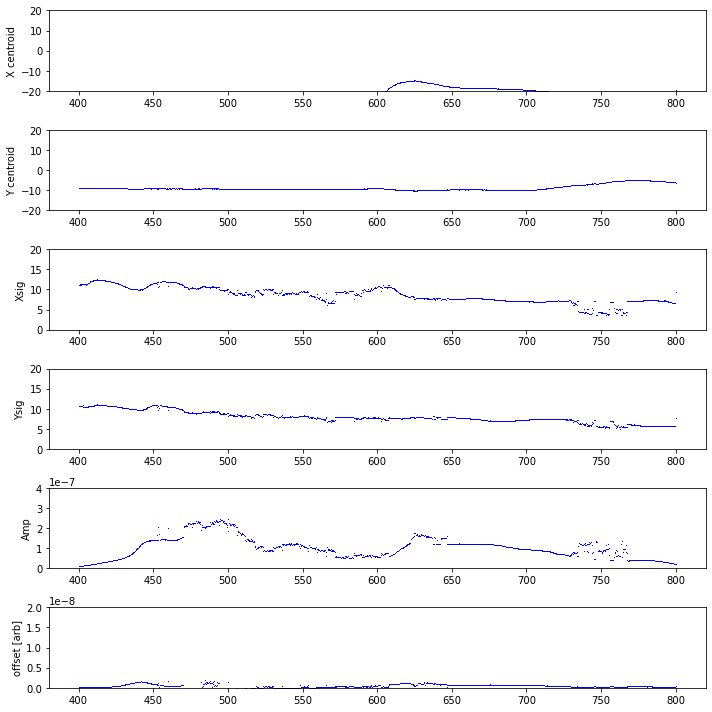

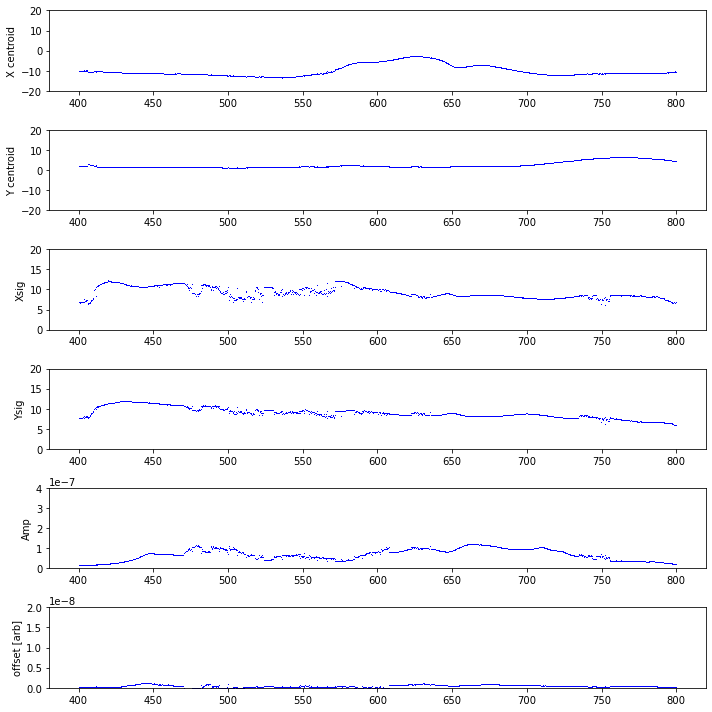

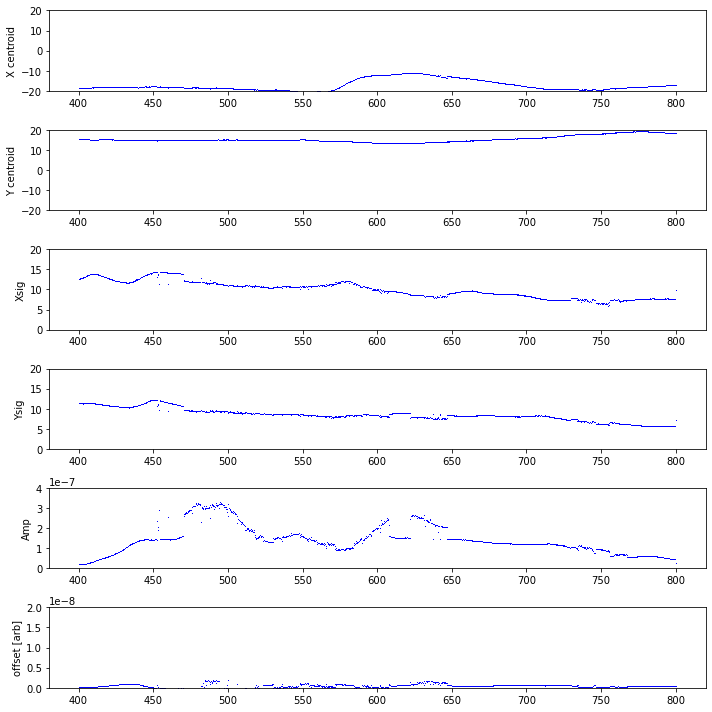

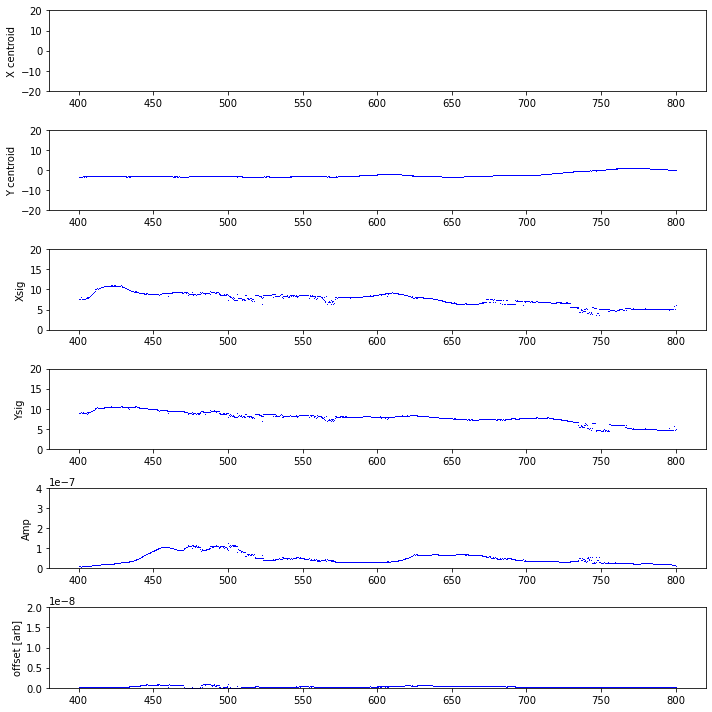

In [6]:
## Investigating co-pol fit values

for d in pols:
    fig, axs = plt.subplots(6,1,figsize=(10,10))
    
    axs[0].plot(freqs,fits['G_popt'][d,:,1],'b,')
    axs[0].set_ylim(-20,20)
    axs[0].set_ylabel('X centroid')
        
    axs[1].plot(freqs,fits['G_popt'][d,:,3],'b,')
    axs[1].set_ylim(-20,20)
    axs[1].set_ylabel('Y centroid')

    axs[2].plot(freqs,fits['G_popt'][d,:,2],'b,')
    axs[2].set_ylim(0,20)
    axs[2].set_ylabel('Xsig')
        
    axs[3].plot(freqs,fits['G_popt'][d,:,4],'b,')
    axs[3].set_ylim(0,20)
    axs[3].set_ylabel('Ysig')

    axs[4].plot(freqs,fits['G_popt'][d,:,0],'b,')
    axs[4].set_ylim(0,4E-7)
    axs[4].set_ylabel('Amp')

    axs[5].plot(freqs,fits['G_popt'][d,:,5],'b,')
    axs[5].set_ylim(0,2E-8)
    axs[5].set_ylabel('offset [arb]')
    fig.tight_layout()
    plt.show()


# 2. Examine Maps


In [7]:
#######################
##### Map Making ######
## check amplitudes ###
#######################

with open(pklfile, 'rb') as inp:
    pconcat = pickle.load(inp)

inds_on_cut=np.intersect1d(np.arange(len(pconcat.t_arr_datetime)),pconcat.inds_on).tolist()
indsuse0 = [j for j in inds_on_cut if str(pconcat.drone_xyz_LC_interp[j,0]) != 'nan']

inds_off_cut=np.intersect1d(np.arange(len(pconcat.t_arr_datetime)),pconcat.inds_off).tolist()
indsoff0 = [j for j in inds_off_cut if str(pconcat.drone_xyz_LC_interp[j,0]) != 'nan']


x = pconcat.drone_xyz_LC_interp[indsuse0,0]
y = pconcat.drone_xyz_LC_interp[indsuse0,1]

xoff = pconcat.drone_xyz_LC_interp[indsoff0,0]
yoff = pconcat.drone_xyz_LC_interp[indsoff0,1]

<ipython-input-8-01312de14ed0>:18: RuntimeWarning: divide by zero encountered in log10
  plt.scatter(xp,yp,s=dotsize, c=10*np.log10(amp_corr), cmap='gnuplot2')
<ipython-input-8-01312de14ed0>:18: RuntimeWarning: invalid value encountered in log10
  plt.scatter(xp,yp,s=dotsize, c=10*np.log10(amp_corr), cmap='gnuplot2')


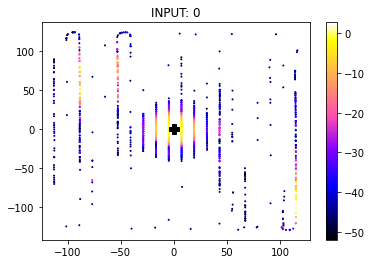

<ipython-input-2-2c599a6e3dbe>:22: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  r = r.astype(np.int)


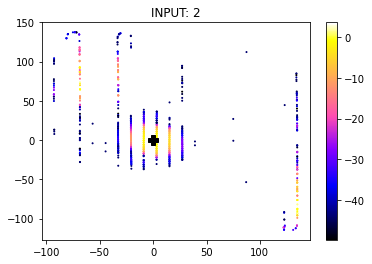

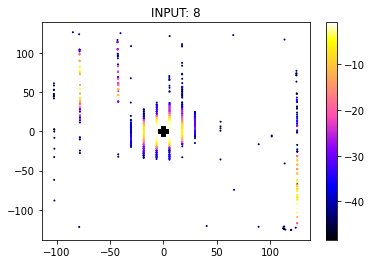

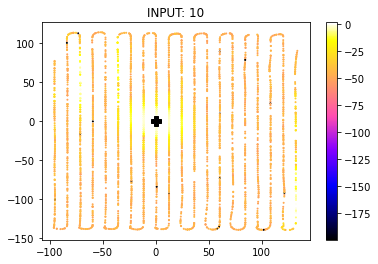

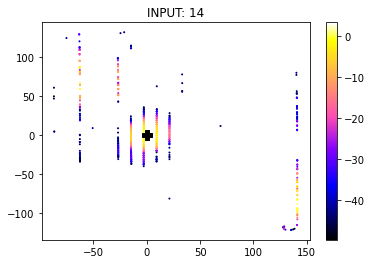

<ipython-input-8-01312de14ed0>:32: RuntimeWarning: divide by zero encountered in log10
  plt.pcolormesh(LX,LY, 10*np.log10(LZs[di,:,:]), shading='auto',cmap='gnuplot2',vmin=0,vmax=-60)
<ipython-input-8-01312de14ed0>:32: RuntimeWarning: invalid value encountered in log10
  plt.pcolormesh(LX,LY, 10*np.log10(LZs[di,:,:]), shading='auto',cmap='gnuplot2',vmin=0,vmax=-60)
No handles with labels found to put in legend.


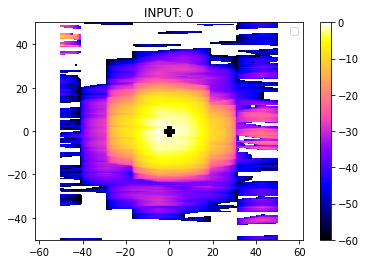

No handles with labels found to put in legend.


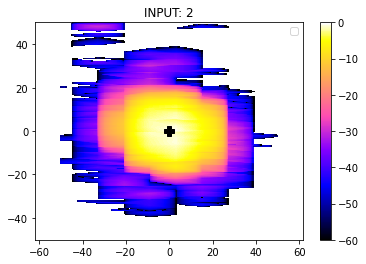

No handles with labels found to put in legend.


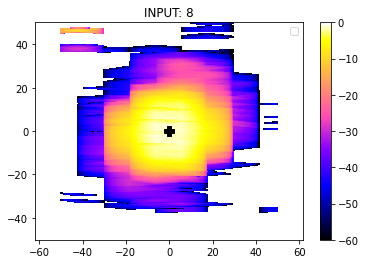

No handles with labels found to put in legend.


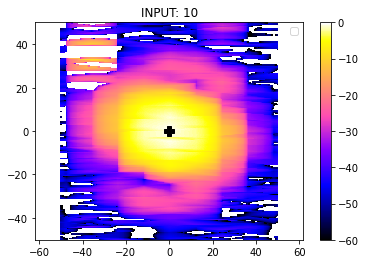

No handles with labels found to put in legend.


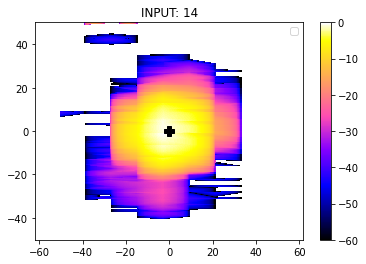

In [8]:
LZs = np.zeros([len(pols),len(LX[:,0]),len(LY[0,:])])
RPs = np.zeros([len(pols),142])

freq_i = 832 
for di in range(0,len(pols)):
    d = pols[di]
    xc = pconcat.G_popt[d,freq_i,1] # x centroid
    yc = pconcat.G_popt[d,freq_i,3] # y centroid
    amp_corr = pconcat.V_bgsub[indsuse0,freq_i,d]/pconcat.G_popt[d,freq_i,0]
                
    #plt.scatter(x,y,s=dotsize, c=amp_corr, cmap='gnuplot2')
    #plt.colorbar()
    #plt.show()  

    xp,yp = get_newpointing(x,y,xc,yc,0.0)       
   
    plt.title('INPUT: '+str(d))
    plt.scatter(xp,yp,s=dotsize, c=10*np.log10(amp_corr), cmap='gnuplot2')
    plt.plot(0,0,color='black',marker='P',markersize=10)
    plt.colorbar()
    plt.show()

    # linear gridding, for reference
    try:
        LZs[di,:,:] = griddata((xp,yp), amp_corr, (LX,LY), method='linear')
        RPs[di,:] = radial_profile(LX,LY,LZs[di,:,:],0,0)
    except: 'Could not linearly interpolate!!!!!'

for di in range(0,len(pols)):
    d = pols[di]
    plt.title('INPUT: '+str(d))
    plt.pcolormesh(LX,LY, 10*np.log10(LZs[di,:,:]), shading='auto',cmap='gnuplot2',vmin=0,vmax=-60)
    plt.plot(0,0,color='black',marker='P',markersize=10)
    plt.legend()
    plt.colorbar()
    plt.axis("equal")
    plt.show()    

<ipython-input-9-160ed2db75e2>:13: RuntimeWarning: divide by zero encountered in log10
  plt.scatter(xp,yp,s=dotsize, c=10*np.log10(amp_corr), cmap='gnuplot2')
<ipython-input-9-160ed2db75e2>:13: RuntimeWarning: invalid value encountered in log10
  plt.scatter(xp,yp,s=dotsize, c=10*np.log10(amp_corr), cmap='gnuplot2')


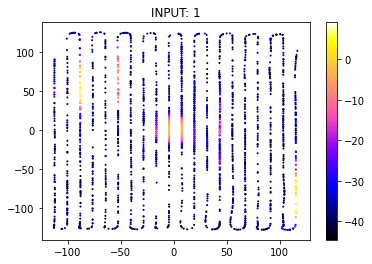

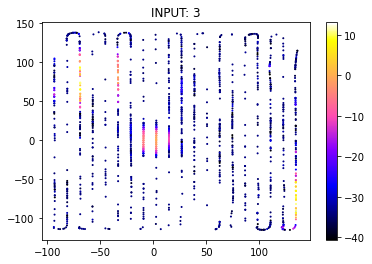

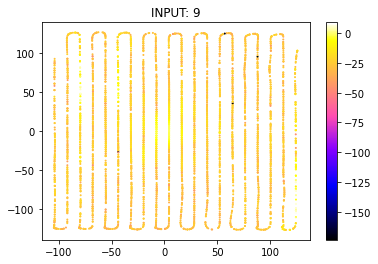

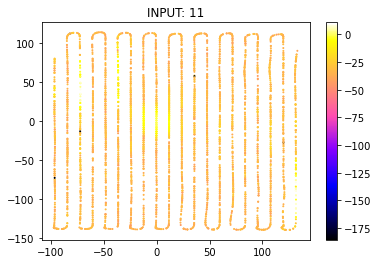

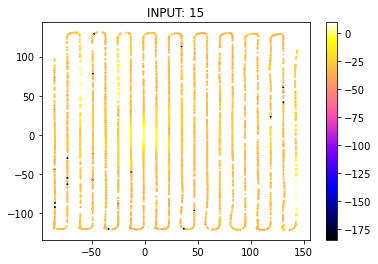

<ipython-input-9-160ed2db75e2>:25: RuntimeWarning: divide by zero encountered in log10
  plt.pcolormesh(LX,LY, 10*np.log10(LZs[di,:,:]), shading='auto',cmap='gnuplot2',vmin=0,vmax=-60)
<ipython-input-9-160ed2db75e2>:25: RuntimeWarning: invalid value encountered in log10
  plt.pcolormesh(LX,LY, 10*np.log10(LZs[di,:,:]), shading='auto',cmap='gnuplot2',vmin=0,vmax=-60)
No handles with labels found to put in legend.


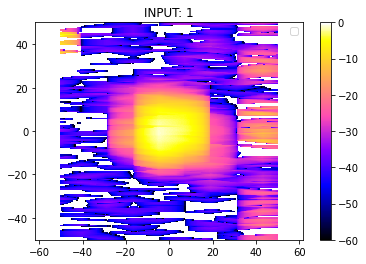

No handles with labels found to put in legend.


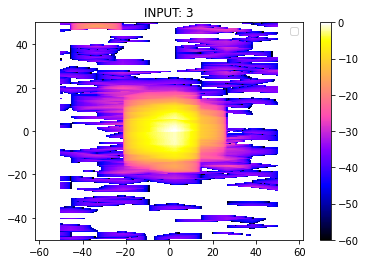

No handles with labels found to put in legend.


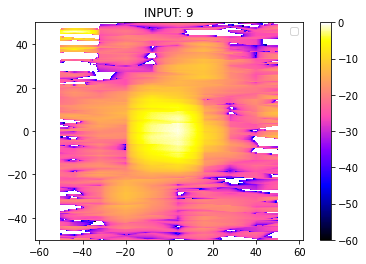

No handles with labels found to put in legend.


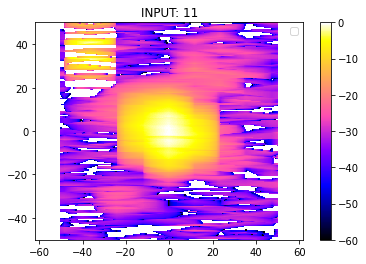

No handles with labels found to put in legend.


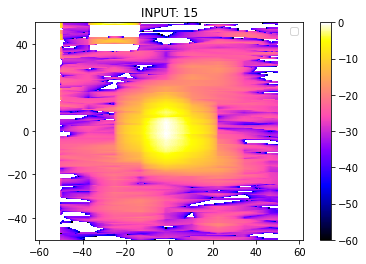

In [9]:
## Look at cross-pol instead

LZs = np.zeros([len(pols),len(LX[:,0]),len(LY[0,:])])

for di in range(0,len(pols)):
    d = cpols[di]
    xc = pconcat.G_popt[d,freq_i,1] # x centroid
    yc = pconcat.G_popt[d,freq_i,3] # y centroid
    amp_corr = pconcat.V_bgsub[indsuse0,freq_i,d]/pconcat.G_popt[d,freq_i,0]

    xp,yp = get_newpointing(x,y,xc,yc,0.0)       
    plt.title('INPUT: '+str(d))
    plt.scatter(xp,yp,s=dotsize, c=10*np.log10(amp_corr), cmap='gnuplot2')
    plt.colorbar()
    plt.show()

    # linear gridding, for reference
    try:
        LZs[di,:,:] = griddata((xp,yp), amp_corr, (LX,LY), method='linear')
    except: 'Could not linearly interpolate!!!!!'

for di in range(0,len(pols)):
    d = cpols[di]
    plt.title('INPUT: '+str(d))
    plt.pcolormesh(LX,LY, 10*np.log10(LZs[di,:,:]), shading='auto',cmap='gnuplot2',vmin=0,vmax=-60)
    plt.legend()
    plt.colorbar()
    plt.axis("equal")
    plt.show()

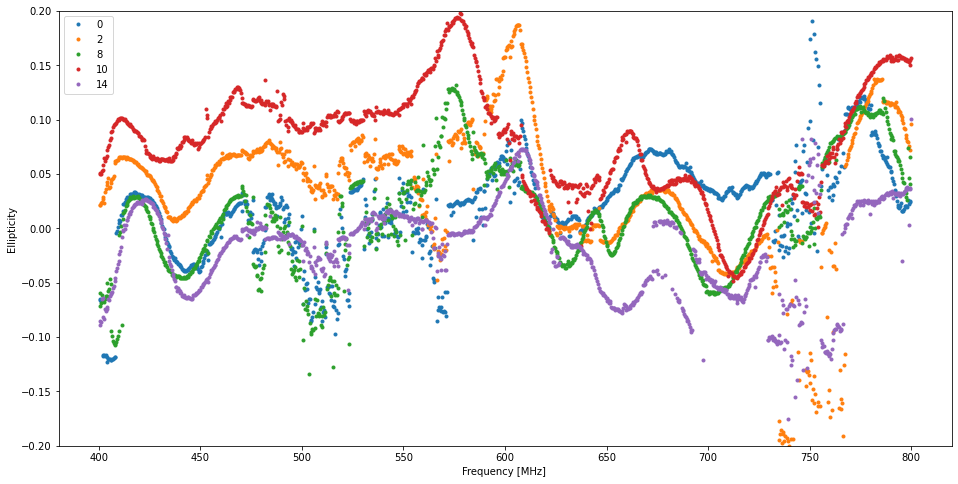

475.0


In [11]:

fig = plt.figure(figsize=(16,8))
for d in pols: 
    ell = (fits['G_popt'][d,:,2]-fits['G_popt'][d,:,4]) / (fits['G_popt'][d,:,2]+fits['G_popt'][d,:,4])
    plt.plot(freqs, ell, marker='.',linestyle='None',label=str(d))
    plt.ylabel('Ellipticity')
    plt.xlabel('Frequency [MHz] ')
    plt.ylim(-0.2,0.2)
plt.legend()
plt.show()

print(freqs[freq_i])

In [19]:
###### Getting some information about which frequencies might be bad from the number of non-zero datapoints:

# Count number of zeros in the data set
#print(pconcat.V_bgsub[indsuse0[0:100],freq_i,0])
#print(np.count_nonzero(pconcat.V_bgsub[indsuse0,freq_i,0])/len(indsuse0))
bfs = []
for d in pols:
    for f in np.arange(512,1024,1):
        #print(f, d, 100*np.count_nonzero(pconcat.V_bgsub[indsuse0,f,d])/len(indsuse0))
        if 100*np.count_nonzero(pconcat.V_bgsub[indsuse0,f,d])/len(indsuse0) < 98.: bfs.append(f)
            
uu = np.array(bfs)
bad_uniq = np.unique(uu)
print(len(bad_uniq),bad_uniq)

# 4. Examine radial profiles

In [ ]:
## Dumb thing first: convert all centroid corrected X, Y
# to r coordinate and overplot Gaussian 


for di in range(0,len(pols)):
    d = pols[di]

    xp,yp = get_newpointing(x,y,pconcat.G_popt[d,freq_i,1],pconcat.G_popt[d,freq_i,3],0.0)  
    
    Gval = Gauss_2d_cent(xp,yp,pconcat.G_popt[d,freq_i,0],
                         pconcat.G_popt[d,freq_i,2],pconcat.G_popt[d,freq_i,4],pconcat.G_popt[d,freq_i,5])
    r = np.sqrt(xp**2 + yp**2)
    plt.plot(r,pconcat.V_bgsub[indsuse0,freq_i,d],'b,')
    xslice = get_slice(xp,yp,'y',0.0,2.0)
    plt.plot(r[xslice],pconcat.V_bgsub[np.array(indsuse0)[xslice.astype(int)],freq_i,d],'r.')
    plt.plot(r,Gval,color='black')
    plt.title('INPUT: '+str(d))
    
    plt.show()


In [ ]:
for di in range(0,len(pols)):
    d = pols[di]
    plt.plot(10*np.log10(RPs[di,:]),label=str(d))
plt.xlim(0,60)
plt.ylim(-30,0)
plt.legend()
plt.show()

In [ ]:
for di in range(0,len(pols)):
    d = pols[di]
    plt.plot(RPs[di,:],label=str(d))
plt.xlim(0,15)
plt.ylim(0,0.9)
plt.legend()
plt.show()

In [ ]:
# 4. Examine Frequency dependence

LZs = np.zeros([len(freqs),len(pols),len(LX[:,0]),len(LY[0,:])])
RPs = np.zeros([len(freqs),len(pols),142])

for di in range(0,len(pols)):
    d = pols[di]
    for f in np.arange(0,len(freqs)):
        xc = pconcat.G_popt[d,f,1] # x centroid
        yc = pconcat.G_popt[d,f,3] # y centroid
        amp_corr = pconcat.V_bgsub[indsuse0,f,d]/pconcat.G_popt[d,f,0]
                
        xp,yp = get_newpointing(x,y,xc,yc,0.0)       

        try:
            LZs[f,di,:,:] = griddata((xp,yp), amp_corr, (LX,LY), method='linear')
            RPs[f,di,:] = radial_profile(LX,LY,LZs[f,di,:,:],0,0)
        except: 'Could not linearly interpolate!!!!!'
    

In [ ]:
di = 0

F = len(freqs)
cm = plt.get_cmap('Spectral')
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.set_prop_cycle(color=[cm(1.*i/F) for i in range(F)])

for f in range(0,len(freqs)):
    plt.plot(RPs[f,di,:],alpha=0.2)
plt.xlim(0,14)
plt.show()

In [ ]:
for di in range(0,len(pols)):
    plt.imshow(10*np.log10(RPs[:,di,:]),vmin=-30,vmax=0,extent=([0, 142, 800, 400]),aspect='auto')
    plt.colorbar()
    plt.xlim(0,60)
    plt.show()

    plt.imshow(RPs[:,di,:],vmin=0,vmax=0.9,extent=([0, 142, 800, 400]),aspect='auto')
    plt.colorbar()
    plt.xlim(0,14)
    plt.show()